<a href="https://colab.research.google.com/github/oleksii-havryliuk/Portfolio_Data_Analyst/blob/main/Python_Project_4_Customer_Retention_Rate_Calculation_For_Uklon_Clients.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **1. Опис бізнес-цілі**










---

> **“If you can’t measure it, you can’t improve it” — Peter Drucker**





---





![Image in a markdown cell](https://i.ytimg.com/vi/X6o_Bm7Kyhk/maxresdefault.jpg)


<br>

>*   Домен: застосунок служби таксі **Uklon**
>*   Департамент маркетингу
>*   Тип даних - *Поведінкові дані*

<br>

---
**БІЗНЕС-ЦІЛЬ:** Компанія **Uklon** хоче з'ясувати те, яким був **Customer Retention Rate** за перший квартал 2022 року (як загалом, так і у розрізі деяких міст), щоб усвідомити вплив початку повномасштабної російсько-української війни на поведінку нових користувачів.

---
<br>

> Для відповіді на даний add-hoc необхідо:
1. Обчіслити Retention N-тижня для клієнтів, які зʼявились у період з січня по березень включно.
2. Обчіслити Retention N-тижня для кожного міста окремо, для клієнтів, які зʼявились у період з січня по березень включно.

**Metrics:**

  
1. **order_id** - ідентифікатор замовлення (STRING) [Таблиця orders]
2. **rider_id** - ідентификатор пасажира (STRING) [Таблиця orders]
3. **city_id** - ідентифікатор міста (INTEGER) [Таблиця orders & Таблиця city]
4. **city_name** - назва міста (STRING) [Таблиця city]
5. **placed_at** - час розміщення замовлення пасажиром. UTC-0 (TIMESTAMP) [Таблиця orders]
6. **Retention rate** (%) - коефіцієнт утримання користувачів, відсоток користувачів, які продовжують використовувати продукт протягом певного періоду часу. Розраховується таким чином:
>**Customer Retention Rate = ([к-ть клієнтів Day N або Week N] - [к-ть нових клієнтів Day N або Week N]) / [к-ть клієнтів на початку періода]**





### **2. Вивантаження даних з BigQuery**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# connect to BQ і забираємо дані

from google.cloud import bigquery
from google.oauth2 import service_account
import pandas as pd

credentials = service_account.Credentials.from_service_account_file('/content/still-entity-383321-1525061e83ce.json') # це мій файл з кредами

project_id = 'still-entity-383321' ## це назва мого проєкту (Name "My First Project", ID	"still-entity-383321")
client = bigquery.Client(credentials=credentials,project=project_id)

#вивантажуємо таблицю orders з BigQuery:

query_text = f"""
select o.*, c.city_name
from junior_da_personal.orders as o
join junior_da_personal.city as c on o.city_id = c.city_id
"""

with client:
    # Run the query and get the results
    query = client.query(query_text)
    orders_df = query.to_dataframe()

print(orders_df.info())
orders_df.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1365382 entries, 0 to 1365381
Data columns (total 20 columns):
 #   Column                   Non-Null Count    Dtype              
---  ------                   --------------    -----              
 0   CITY_ID                  1365382 non-null  Int64              
 1   PRODUCT                  1365382 non-null  object             
 2   ORDER_AMOUNT             1365382 non-null  Int64              
 3   MULTIPLIER               1365382 non-null  float64            
 4   PROMO_AMOUNT             363794 non-null   float64            
 5   ORDER_ID                 1365382 non-null  object             
 6   PLACED_AT                1365382 non-null  datetime64[ns, UTC]
 7   ACCEPTED_AT              1121691 non-null  datetime64[ns, UTC]
 8   COMPLETED_AT             1027584 non-null  datetime64[ns, UTC]
 9   CANCELLED_AT             409591 non-null   datetime64[ns, UTC]
 10  ROUTE_DISTANCE           1365382 non-null  Int64              
 11

,CITY_ID,PRODUCT,ORDER_AMOUNT,MULTIPLIER,PROMO_AMOUNT,ORDER_ID,PLACED_AT,ACCEPTED_AT,COMPLETED_AT,CANCELLED_AT,ROUTE_DISTANCE,ROUTE_SUBURBAN_DISTANCE,RIDER_ID,DRIVER_ID,VEHICLE_ID,CANCEL_REASON,PAYMENT_TYPE,PICKUP_POINT,DROPOFF_POINT,city_name
0,1006,Standard,92,1.0,20.0,5e507c31-8204-5263-ac9b-ea0197a4dd54,2022-06-01 10:35:35+00:00,NaT,NaT,2022-06-01 10:44:49+00:00,10285,0,7d6235fa-d6ee-57b2-bffa-b62a621f62e7,None,None,CANCELLATION_REASON_RIDER_TIMEOUT,PAYMENT_TYPE_CASH,"{\n ""coordinates"": [\n 3.512948000000000e+...","{\n ""coordinates"": [\n 3.503262000000000e+...",Zaporizhia
1,1006,Standard,99,1.7,NaN,4481f37b-2b87-5be6-be78-0a91106baf68,2022-06-01 12:34:45+00:00,NaT,NaT,2022-06-01 12:37:24+00:00,5670,0,671e4195-d947-51fc-b015-9cc4804538c6,None,None,CANCELLATION_REASON_RIDER_TIMEOUT,PAYMENT_TYPE_CASH,"{\n ""coordinates"": [\n 3.510667000000000e+...","{\n ""coordinates"": [\n 3.505636000000000e+...",Zaporizhia


In [ ]:
#переводимо назви колонок у нижній регістр
orders_df.columns = orders_df.columns.str.lower()
orders_df.head(2)

,city_id,product,order_amount,multiplier,promo_amount,order_id,placed_at,accepted_at,completed_at,cancelled_at,route_distance,route_suburban_distance,rider_id,driver_id,vehicle_id,cancel_reason,payment_type,pickup_point,dropoff_point,city_name
0,1006,Standard,92,1.0,20.0,5e507c31-8204-5263-ac9b-ea0197a4dd54,2022-06-01 10:35:35+00:00,NaT,NaT,2022-06-01 10:44:49+00:00,10285,0,7d6235fa-d6ee-57b2-bffa-b62a621f62e7,None,None,CANCELLATION_REASON_RIDER_TIMEOUT,PAYMENT_TYPE_CASH,"{\n ""coordinates"": [\n 3.512948000000000e+...","{\n ""coordinates"": [\n 3.503262000000000e+...",Zaporizhia
1,1006,Standard,99,1.7,NaN,4481f37b-2b87-5be6-be78-0a91106baf68,2022-06-01 12:34:45+00:00,NaT,NaT,2022-06-01 12:37:24+00:00,5670,0,671e4195-d947-51fc-b015-9cc4804538c6,None,None,CANCELLATION_REASON_RIDER_TIMEOUT,PAYMENT_TYPE_CASH,"{\n ""coordinates"": [\n 3.510667000000000e+...","{\n ""coordinates"": [\n 3.505636000000000e+...",Zaporizhia


### **3. Розрахунок Customer Retention Rate**

In [ ]:
# Змінемо тип даних для часу розміщення замовлення
orders_df['placed_at'] = pd.to_datetime(orders_df['placed_at'])

In [ ]:
# Для кожного пасажира порахуємо дату першого замовлення

first_order = orders_df.groupby(['rider_id'])[['placed_at']].min().reset_index()
first_order['placed_at'] = pd.to_datetime(first_order['placed_at']).dt.date
first_order = first_order.rename(columns = {'placed_at':'first_date'})
first_order

,rider_id,first_date
0,00000c6b-7227-5b8f-a5ac-073c16ad542f,2022-04-03
1,000022b4-1ae0-5c53-a98e-7a9a7e10f68c,2022-05-20
2,00002670-8e9e-54d1-8b84-5fec06fe5b5e,2022-03-03
3,000077c1-ad9c-573e-babd-d18a2dae7c6d,2022-01-28
4,0000860c-efa4-5661-a16c-de0efb5a7dbb,2022-01-01
...,...,...
280065,fffe95bc-4393-5039-bb35-6417ee6d7131,2022-01-02
280066,fffecc25-5b73-5985-8994-4305800bf25d,2022-01-08
280067,fffee158-1219-5641-865d-b769413a0d53,2022-01-31
280068,ffff1954-877c-56c9-b85e-360930133885,2022-01-10


In [ ]:
# Доєднаємо дані про перше замовлення для кожного пасажира до нашого датафрейму orders_df
orders_df = orders_df.merge(first_order, on = ['rider_id'])
orders_df.head(2)

,city_id,product,order_amount,multiplier,promo_amount,order_id,placed_at,accepted_at,completed_at,cancelled_at,...,route_suburban_distance,rider_id,driver_id,vehicle_id,cancel_reason,payment_type,pickup_point,dropoff_point,city_name,first_date
0,1006,Standard,92,1.00,20.0,5e507c31-8204-5263-ac9b-ea0197a4dd54,2022-06-01 10:35:35+00:00,NaT,NaT,2022-06-01 10:44:49+00:00,...,0,7d6235fa-d6ee-57b2-bffa-b62a621f62e7,None,None,CANCELLATION_REASON_RIDER_TIMEOUT,PAYMENT_TYPE_CASH,"{\n ""coordinates"": [\n 3.512948000000000e+...","{\n ""coordinates"": [\n 3.503262000000000e+...",Zaporizhia,2022-01-07
1,1006,Standard,85,1.06,13.0,c604be00-2761-5a17-90c0-9d4254021da7,2022-01-20 07:44:14+00:00,2022-01-20 07:44:31+00:00,2022-01-20 08:13:18+00:00,NaT,...,0,7d6235fa-d6ee-57b2-bffa-b62a621f62e7,96e43e33-7657-509f-b10c-d2d506ae4cf6,3365fdb4-f67e-55f4-a129-02893c7c3b80,None,PAYMENT_TYPE_CASH,"{\n ""coordinates"": [\n 3.502448000000000e+...","{\n ""coordinates"": [\n 3.512241000000000e+...",Zaporizhia,2022-01-07


In [ ]:
# Обмежемо датафрейм лише колонками, які потрібні для розрахунку Customer Retention Rate
orders_df = orders_df[['order_id', 'rider_id', 'city_name', 'first_date', 'placed_at']]
orders_df.head(2)

,order_id,rider_id,city_name,first_date,placed_at
0,5e507c31-8204-5263-ac9b-ea0197a4dd54,7d6235fa-d6ee-57b2-bffa-b62a621f62e7,Zaporizhia,2022-01-07,2022-06-01 10:35:35+00:00
1,c604be00-2761-5a17-90c0-9d4254021da7,7d6235fa-d6ee-57b2-bffa-b62a621f62e7,Zaporizhia,2022-01-07,2022-01-20 07:44:14+00:00


In [ ]:
# Підраховуємо кількість днів та тижнів з моменту першого замовлення для кожного наступного замовлення клієнта
import numpy as np

orders_df['day_num'] = (orders_df['placed_at'].dt.date - orders_df['first_date']) / np.timedelta64(1, 'D')
orders_df['week_num'] = round((orders_df['placed_at'].dt.date - orders_df['first_date']) / np.timedelta64(1, 'W'), 0)

orders_df = orders_df[['order_id', 'rider_id', 'city_name', 'first_date', 'placed_at', 'day_num', 'week_num']]

orders_df

,order_id,rider_id,city_name,first_date,placed_at,day_num,week_num
0,5e507c31-8204-5263-ac9b-ea0197a4dd54,7d6235fa-d6ee-57b2-bffa-b62a621f62e7,Zaporizhia,2022-01-07,2022-06-01 10:35:35+00:00,145.0,21.0
1,c604be00-2761-5a17-90c0-9d4254021da7,7d6235fa-d6ee-57b2-bffa-b62a621f62e7,Zaporizhia,2022-01-07,2022-01-20 07:44:14+00:00,13.0,2.0
2,73a22300-42a9-58cc-971b-8c335c0fe7ec,7d6235fa-d6ee-57b2-bffa-b62a621f62e7,Zaporizhia,2022-01-07,2022-06-07 16:40:49+00:00,151.0,22.0
3,8bc11b76-a63e-543e-ac4c-4fc21300d9e3,7d6235fa-d6ee-57b2-bffa-b62a621f62e7,Zaporizhia,2022-01-07,2022-01-07 17:09:54+00:00,0.0,0.0
4,b28b1164-9010-537a-8550-df610be9eab4,7d6235fa-d6ee-57b2-bffa-b62a621f62e7,Zaporizhia,2022-01-07,2022-06-03 15:24:55+00:00,147.0,21.0
...,...,...,...,...,...,...,...
1365377,089340e0-1cd7-533f-978f-217138c86063,6b266cf9-d1a4-52a4-8216-da901a0660b2,Vinnytsia,2022-02-12,2022-02-12 23:17:14+00:00,0.0,0.0
1365378,e33b3015-f4bc-5b43-a2fb-fd45c60c548c,ae74dda4-5b31-51f4-856b-fa7c23456c7e,Vinnytsia,2022-06-23,2022-06-23 12:08:53+00:00,0.0,0.0
1365379,cf2eb754-4962-55b3-a5c9-34c8ae850eb9,0a930a16-945f-5628-8df7-9a0b03555a1c,Vinnytsia,2022-02-14,2022-02-14 19:41:04+00:00,0.0,0.0
1365380,9682d9ac-43ad-50ce-802d-830498af4b92,9e3747ce-52c4-554e-93fd-904e2bde7bc5,Vinnytsia,2022-02-11,2022-02-11 21:47:53+00:00,0.0,0.0


In [ ]:
# Обмежемо датафрейм лише датами, які потрібні для розрахунку Customer Retention Rate за січень-березень

Q1_orders_df = orders_df[(orders_df.placed_at >= '2022-01-01') & (orders_df.placed_at <= '2022-03-31')]
Q1_orders_df.sort_values(by=['placed_at'])

,order_id,rider_id,city_name,first_date,placed_at,day_num,week_num
459604,376a063e-0925-505a-94d0-94141bab9ad1,620435b7-3fb9-524d-86ec-868b9ca63ea4,Zaporizhia,2022-01-01,2022-01-01 00:00:04+00:00,0.0,0.0
969186,fbf39b9a-f288-5c9f-9db4-786e99f92f88,b97c26da-6eb5-57f5-bf7a-d0464ddd9ce6,Vinnytsia,2022-01-01,2022-01-01 00:00:11+00:00,0.0,0.0
354208,d4017739-a12f-50d7-846f-a5e8d1c6e0df,0f7cce69-b663-54ce-9378-b92d18f17f48,Zhytomyr,2022-01-01,2022-01-01 00:00:12+00:00,0.0,0.0
994050,4674ec87-179e-5175-8d06-ecf15044a1a8,e14929c8-70e6-5331-86c0-fb83789d15d7,Vinnytsia,2022-01-01,2022-01-01 00:00:13+00:00,0.0,0.0
161312,8ef99831-2974-503b-8306-bd6aae9da9ec,2630f3b6-3aee-522a-9bde-40296edf41b2,Zaporizhia,2022-01-01,2022-01-01 00:00:16+00:00,0.0,0.0
...,...,...,...,...,...,...,...
269244,d955b7b2-27a6-56c9-9bc8-81685078d70a,53d68987-1fb8-58e6-8c0d-3bb147c227b6,Ivano-Frankivsk,2022-03-05,2022-03-30 23:09:12+00:00,25.0,4.0
864948,4b50847b-6b8e-5edf-a2d7-a76bdb7ed534,4f4a0d0f-5ca3-53e5-af51-88e07217b05c,Khmelnytskyi,2022-01-26,2022-03-30 23:15:46+00:00,63.0,9.0
918816,95857ee4-09b5-56c1-ad2e-5d4485846c61,a14aa65e-9b1f-54f1-9a9b-f7a5765b500d,Khmelnytskyi,2022-01-27,2022-03-30 23:21:23+00:00,62.0,9.0
753642,20895b0d-276d-5b74-8962-97d902082d02,8f823f12-5653-55b3-8ec5-bae7c97b55c9,Rivne,2022-01-09,2022-03-30 23:30:25+00:00,80.0,11.0


In [ ]:
Q1_orders_df['first_date'] = pd.to_datetime(Q1_orders_df['first_date'])

# Отримання номера тижня для кожного значення 'first_date'
Q1_orders_df['first_week'] = Q1_orders_df['first_date'].dt.week
# Трансформуємо колонку first_week, адже 1 та 2 січня були днями останнього 52-го тижня 2021 року
Q1_orders_df['first_week'] = Q1_orders_df['first_week'].apply(lambda x: 0 if x == 52 else x)

Q1_orders_df

<ipython-input-10-de9488fe242b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Q1_orders_df['first_date'] = pd.to_datetime(Q1_orders_df['first_date'])
<ipython-input-10-de9488fe242b>:4: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  Q1_orders_df['first_week'] = Q1_orders_df['first_date'].dt.week
<ipython-input-10-de9488fe242b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Q1_orders_df['first_week'] = Q1_orders_df['first_da

,order_id,rider_id,city_name,first_date,placed_at,day_num,week_num,first_week
1,c604be00-2761-5a17-90c0-9d4254021da7,7d6235fa-d6ee-57b2-bffa-b62a621f62e7,Zaporizhia,2022-01-07,2022-01-20 07:44:14+00:00,13.0,2.0,1
3,8bc11b76-a63e-543e-ac4c-4fc21300d9e3,7d6235fa-d6ee-57b2-bffa-b62a621f62e7,Zaporizhia,2022-01-07,2022-01-07 17:09:54+00:00,0.0,0.0,1
5,920c4110-2d92-5b3f-b984-aa45a897f0ba,7d6235fa-d6ee-57b2-bffa-b62a621f62e7,Zaporizhia,2022-01-07,2022-01-28 18:50:35+00:00,21.0,3.0,1
6,cf242ad9-a77e-58dd-b9b0-525b03ef06e8,7d6235fa-d6ee-57b2-bffa-b62a621f62e7,Zaporizhia,2022-01-07,2022-01-24 18:23:44+00:00,17.0,2.0,1
7,f94933a9-c251-533d-ba8d-3cd5e95632a4,7d6235fa-d6ee-57b2-bffa-b62a621f62e7,Zaporizhia,2022-01-07,2022-02-15 19:15:22+00:00,39.0,6.0,1
...,...,...,...,...,...,...,...,...
1365372,ba211832-7503-5b7d-ad0f-ea35501be982,2659cbe8-4d37-5b54-b621-1d4d083bd0ca,Vinnytsia,2022-01-25,2022-01-25 06:58:28+00:00,0.0,0.0,4
1365377,089340e0-1cd7-533f-978f-217138c86063,6b266cf9-d1a4-52a4-8216-da901a0660b2,Vinnytsia,2022-02-12,2022-02-12 23:17:14+00:00,0.0,0.0,6
1365379,cf2eb754-4962-55b3-a5c9-34c8ae850eb9,0a930a16-945f-5628-8df7-9a0b03555a1c,Vinnytsia,2022-02-14,2022-02-14 19:41:04+00:00,0.0,0.0,7
1365380,9682d9ac-43ad-50ce-802d-830498af4b92,9e3747ce-52c4-554e-93fd-904e2bde7bc5,Vinnytsia,2022-02-11,2022-02-11 21:47:53+00:00,0.0,0.0,6


In [ ]:
# Розраховуємо Customer Retention Rate для клієнтів, які прийшли до нас за перший квартал 2022 року

retention_data = Q1_orders_df.groupby(['first_week', 'week_num'])[['rider_id']].nunique() #кількість унікальних пасажирів для кожного дня тижня
retention_data['rider_percent'] = Q1_orders_df.groupby(['first_week', 'week_num'])[['rider_id']].nunique()/Q1_orders_df.groupby(['first_week'])[['rider_id']].nunique()*100
retention_data = retention_data.reset_index()

retention_data

,first_week,week_num,rider_id,rider_percent
0,0,0.0,23954,100.000000
1,0,1.0,8182,34.157135
2,0,2.0,7664,31.994656
3,0,3.0,6239,26.045754
4,0,4.0,5559,23.206980
...,...,...,...,...
100,11,1.0,1316,23.366477
101,11,2.0,551,9.783381
102,12,0.0,5316,100.000000
103,12,1.0,626,11.775771


In [ ]:
pd.pivot_table(retention_data,
              values='rider_id',
              index=['first_week'],
              columns=['week_num'],
              aggfunc=np.sum).iloc[0:, :10].fillna(0).style.background_gradient(cmap = 'Blues')

week_num,0.000000,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000
first_week,,,,,,,,,,
0,23954.000000,8182.000000,7664.000000,6239.000000,5559.000000,5153.000000,5780.000000,5482.000000,3699.000000,2264.000000
1,39982.000000,12859.000000,11228.000000,9467.000000,8608.000000,9248.000000,9419.000000,7685.000000,3625.000000,3354.000000
2,28879.000000,8026.000000,6582.000000,5749.000000,5701.000000,6174.000000,4911.000000,2118.000000,1989.000000,1898.000000
3,20281.000000,4255.000000,3603.000000,3395.000000,3383.000000,2845.000000,1195.000000,1136.000000,1147.000000,1199.000000
4,16421.000000,3015.000000,2362.000000,2459.000000,1931.000000,885.000000,778.000000,783.000000,766.000000,421.000000
5,13827.000000,2468.000000,2064.000000,1653.000000,742.000000,659.000000,632.000000,694.000000,318.000000,0.000000
6,13708.000000,2330.000000,1583.000000,686.000000,632.000000,639.000000,574.000000,257.000000,0.000000,0.000000
7,13994.000000,1969.000000,762.000000,710.000000,616.000000,649.000000,300.000000,0.000000,0.000000,0.000000
8,11622.000000,1136.000000,858.000000,762.000000,701.000000,292.000000,0.000000,0.000000,0.000000,0.000000


In [ ]:
pd.pivot_table(retention_data,
              values='rider_percent',
              index=['first_week'],
              columns=['week_num'],
              aggfunc=np.sum).iloc[0:, :10].fillna(0).style.background_gradient(cmap = 'Blues')

week_num,0.000000,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000
first_week,,,,,,,,,,
0,100.000000,34.157135,31.994656,26.045754,23.206980,21.512065,24.129582,22.885531,15.442097,9.451449
1,100.000000,32.161973,28.082637,23.678155,21.529688,23.130409,23.558101,19.221150,9.066580,8.388775
2,100.000000,27.791821,22.791648,19.907199,19.740988,21.378857,17.005436,7.334049,6.887358,6.572250
3,100.000000,20.980228,17.765396,16.739806,16.680637,14.027908,5.892214,5.601302,5.655540,5.911937
4,100.000000,18.360636,14.384020,14.974727,11.759333,5.389440,4.737836,4.768285,4.664759,2.563790
5,100.000000,17.849136,14.927316,11.954871,5.366312,4.766037,4.570767,5.019165,2.299848,0.000000
6,100.000000,16.997374,11.548001,5.004377,4.610446,4.661512,4.187336,1.874818,0.000000,0.000000
7,100.000000,14.070316,5.445191,5.073603,4.401887,4.637702,2.143776,0.000000,0.000000,0.000000
8,100.000000,9.774565,7.382550,6.556531,6.031664,2.512476,0.000000,0.000000,0.000000,0.000000


**Висновок:**

Спираючись на результати загального розрахунку **Customer Retention Rate** (див. вище)  видно, що відносний показник **Customer Retention Rate Week1** за восьмий тиждень (2022-21-02 по 2022-27-02) першого кварталу 2022 року був найменшим за весь досліджуваний період - 9.7%. Згодом (Week9-Week11), фіксувалося різке зростання частки клієнтів, які поверталися до продукту через 1 тиждень, але варто обачно ставитися до інтерпретації таких результатів, адже абсолютне значення нових користувачів протягом даних тижнів зменшувалось, що, в свою чергу, вплинуло на абсолюний **Customer Retention Rate Week1**. Зокрема, абсолюний середній **Customer Retention Rate Week1** для Week8-Week12 у рази менший, ніж середнє значення у довоєнних тижнів першого кварталу. Наприклад, абсолютне значення **Customer Retention Rate Week1** для Week1 сягало 13 тис. із 40 тис. нових клієнтів напротивагу значенню цього ж показника для Week12 - 0.6 тис. із 5.3 тис. нових клієнтів. Схожа ситуація спостерігалася і у досліджуваних містах (див. нижче), хоча більш менш несприятлива картина була у облцентрах західних регіонів України, що пояснюється міграційними хвилями, які проходили через території цих регіонів.        

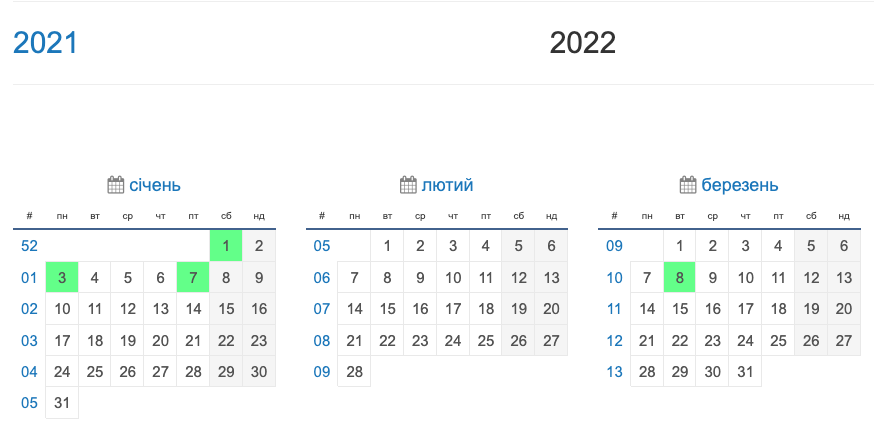

In [ ]:
from IPython.display import Image

display(Image("Num_Week_Q1_2022.png"))

In [ ]:
Q1_orders_df.city_name.value_counts()

Zaporizhia         233570
Vinnytsia          155624
Ivano-Frankivsk    131239
Rivne               91869
Zhytomyr            79655
Khmelnytskyi        61090
Name: city_name, dtype: int64

In [ ]:
# Розраховуємо Customer Retention Rate для клієнтів, які прийшли до нас за перший квартал 2022 року для м. Запоріжжя

retention_Zaporizhia = Q1_orders_df[Q1_orders_df['city_name'] == "Zaporizhia"].groupby(['first_week', 'week_num'])[['rider_id']].nunique() #кількість унікальних пасажирів для кожного дня тижня
retention_Zaporizhia['rider_percent'] = Q1_orders_df[Q1_orders_df['city_name'] == "Zaporizhia"].groupby(['first_week', 'week_num'])[['rider_id']].nunique()/Q1_orders_df[Q1_orders_df['city_name'] == "Zaporizhia"].groupby(['first_week'])[['rider_id']].nunique()*100
retention_Zaporizhia = round(retention_Zaporizhia.reset_index(), 0)

retention_Zaporizhia

,first_week,week_num,rider_id,rider_percent
0,0,0.0,8323,100.0
1,0,1.0,2768,33.0
2,0,2.0,2588,31.0
3,0,3.0,2202,26.0
4,0,4.0,1919,23.0
...,...,...,...,...
100,11,1.0,166,15.0
101,11,2.0,69,6.0
102,12,0.0,893,100.0
103,12,1.0,77,9.0


In [ ]:
pd.pivot_table(retention_Zaporizhia,
              values='rider_id',
              index=['first_week'],
              columns=['week_num'],
              aggfunc=np.sum).iloc[0:, :10].fillna(0).style.background_gradient(cmap = 'BuGn')

week_num,0.000000,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000
first_week,,,,,,,,,,
0,8323.000000,2768.000000,2588.000000,2202.000000,1919.000000,1697.000000,1883.000000,1783.000000,1434.000000,856.000000
1,12727.000000,4088.000000,3670.000000,3073.000000,2740.000000,2875.000000,2885.000000,2619.000000,1361.000000,1033.000000
2,8685.000000,2545.000000,1947.000000,1720.000000,1582.000000,1766.000000,1498.000000,737.000000,564.000000,549.000000
3,6346.000000,1352.000000,1065.000000,896.000000,990.000000,893.000000,466.000000,334.000000,322.000000,309.000000
4,5087.000000,844.000000,619.000000,701.000000,628.000000,343.000000,216.000000,226.000000,174.000000,87.000000
5,4104.000000,681.000000,535.000000,485.000000,259.000000,198.000000,184.000000,173.000000,75.000000,0.000000
6,3894.000000,608.000000,448.000000,268.000000,190.000000,197.000000,143.000000,68.000000,0.000000,0.000000
7,3809.000000,554.000000,238.000000,210.000000,161.000000,146.000000,52.000000,0.000000,0.000000,0.000000
8,3649.000000,455.000000,298.000000,267.000000,206.000000,78.000000,0.000000,0.000000,0.000000,0.000000


In [ ]:
pd.pivot_table(retention_Zaporizhia,
              values='rider_percent',
              index=['first_week'],
              columns=['week_num'],
              aggfunc=np.sum).iloc[0:, :10].fillna(0).style.background_gradient(cmap = 'BuGn')

week_num,0.000000,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000
first_week,,,,,,,,,,
0,100.000000,33.000000,31.000000,26.000000,23.000000,20.000000,23.000000,21.000000,17.000000,10.000000
1,100.000000,32.000000,29.000000,24.000000,21.000000,23.000000,23.000000,21.000000,11.000000,8.000000
2,100.000000,29.000000,22.000000,20.000000,18.000000,20.000000,17.000000,8.000000,6.000000,6.000000
3,100.000000,21.000000,17.000000,14.000000,16.000000,14.000000,7.000000,5.000000,5.000000,5.000000
4,100.000000,17.000000,12.000000,14.000000,12.000000,7.000000,4.000000,4.000000,3.000000,2.000000
5,100.000000,17.000000,13.000000,12.000000,6.000000,5.000000,4.000000,4.000000,2.000000,0.000000
6,100.000000,16.000000,11.000000,7.000000,5.000000,5.000000,4.000000,2.000000,0.000000,0.000000
7,100.000000,15.000000,6.000000,6.000000,4.000000,4.000000,1.000000,0.000000,0.000000,0.000000
8,100.000000,12.000000,8.000000,7.000000,6.000000,2.000000,0.000000,0.000000,0.000000,0.000000


In [ ]:
# Розраховуємо Customer Retention Rate для клієнтів, які прийшли до нас за перший квартал 2022 року для м. Вінниця

retention_Vinnytsia = Q1_orders_df[Q1_orders_df['city_name'] == "Vinnytsia"].groupby(['first_week', 'week_num'])[['rider_id']].nunique() #кількість унікальних пасажирів для кожного дня тижня
retention_Vinnytsia['rider_percent'] = Q1_orders_df[Q1_orders_df['city_name'] == "Vinnytsia"].groupby(['first_week', 'week_num'])[['rider_id']].nunique()/Q1_orders_df[Q1_orders_df['city_name'] == "Vinnytsia"].groupby(['first_week'])[['rider_id']].nunique()*100
retention_Vinnytsia = round(retention_Vinnytsia.reset_index(), 0)

retention_Vinnytsia

,first_week,week_num,rider_id,rider_percent
0,0,0.0,4556,98.0
1,0,1.0,1644,36.0
2,0,2.0,1573,34.0
3,0,3.0,1172,25.0
4,0,4.0,1070,23.0
...,...,...,...,...
100,11,1.0,304,23.0
101,11,2.0,116,9.0
102,12,0.0,1260,100.0
103,12,1.0,139,11.0


In [ ]:
pd.pivot_table(retention_Vinnytsia,
              values='rider_id',
              index=['first_week'],
              columns=['week_num'],
              aggfunc=np.sum).iloc[0:, :10].fillna(0).style.background_gradient(cmap = 'PuBuGn')

week_num,0.000000,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000
first_week,,,,,,,,,,
0,4556.000000,1644.000000,1573.000000,1172.000000,1070.000000,1025.000000,1172.000000,1088.000000,663.000000,438.000000
1,8573.000000,2862.000000,2410.000000,2071.000000,1845.000000,2000.000000,2029.000000,1566.000000,739.000000,720.000000
2,6604.000000,1787.000000,1473.000000,1329.000000,1317.000000,1469.000000,1110.000000,441.000000,482.000000,433.000000
3,3903.000000,861.000000,663.000000,679.000000,653.000000,523.000000,198.000000,220.000000,235.000000,246.000000
4,3277.000000,565.000000,468.000000,526.000000,354.000000,149.000000,149.000000,157.000000,144.000000,103.000000
5,2560.000000,433.000000,403.000000,304.000000,127.000000,116.000000,130.000000,122.000000,60.000000,0.000000
6,2421.000000,385.000000,266.000000,104.000000,125.000000,105.000000,112.000000,43.000000,0.000000,0.000000
7,2635.000000,349.000000,137.000000,140.000000,110.000000,133.000000,63.000000,0.000000,0.000000,0.000000
8,2186.000000,157.000000,146.000000,118.000000,126.000000,47.000000,0.000000,0.000000,0.000000,0.000000


In [ ]:
pd.pivot_table(retention_Vinnytsia,
              values='rider_percent',
              index=['first_week'],
              columns=['week_num'],
              aggfunc=np.sum).iloc[0:, :10].fillna(0).style.background_gradient(cmap = 'PuBuGn')

week_num,0.000000,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000
first_week,,,,,,,,,,
0,98.000000,36.000000,34.000000,25.000000,23.000000,22.000000,25.000000,24.000000,14.000000,9.000000
1,99.000000,33.000000,28.000000,24.000000,21.000000,23.000000,23.000000,18.000000,9.000000,8.000000
2,99.000000,27.000000,22.000000,20.000000,20.000000,22.000000,17.000000,7.000000,7.000000,6.000000
3,99.000000,22.000000,17.000000,17.000000,17.000000,13.000000,5.000000,6.000000,6.000000,6.000000
4,99.000000,17.000000,14.000000,16.000000,11.000000,5.000000,5.000000,5.000000,4.000000,3.000000
5,99.000000,17.000000,16.000000,12.000000,5.000000,5.000000,5.000000,5.000000,2.000000,0.000000
6,100.000000,16.000000,11.000000,4.000000,5.000000,4.000000,5.000000,2.000000,0.000000,0.000000
7,100.000000,13.000000,5.000000,5.000000,4.000000,5.000000,2.000000,0.000000,0.000000,0.000000
8,99.000000,7.000000,7.000000,5.000000,6.000000,2.000000,0.000000,0.000000,0.000000,0.000000


In [ ]:
# Розраховуємо Customer Retention Rate для клієнтів, які прийшли до нас за перший квартал 2022 року для м. Івано-Франківськ

retention_IF = Q1_orders_df[Q1_orders_df['city_name'] == "Ivano-Frankivsk"].groupby(['first_week', 'week_num'])[['rider_id']].nunique() #кількість унікальних пасажирів для кожного дня тижня
retention_IF['rider_percent'] = Q1_orders_df[Q1_orders_df['city_name'] == "Ivano-Frankivsk"].groupby(['first_week', 'week_num'])[['rider_id']].nunique()/Q1_orders_df[Q1_orders_df['city_name'] == "Ivano-Frankivsk"].groupby(['first_week'])[['rider_id']].nunique()*100
retention_IF = round(retention_IF.reset_index(), 0)

retention_IF

,first_week,week_num,rider_id,rider_percent
0,0,0.0,3741,99.0
1,0,1.0,1239,33.0
2,0,2.0,1172,31.0
3,0,3.0,961,25.0
4,0,4.0,949,25.0
...,...,...,...,...
100,11,1.0,403,28.0
101,11,2.0,175,12.0
102,12,0.0,1457,100.0
103,12,1.0,192,13.0


In [ ]:
pd.pivot_table(retention_IF,
              values='rider_id',
              index=['first_week'],
              columns=['week_num'],
              aggfunc=np.sum).iloc[0:, :10].fillna(0).style.background_gradient(cmap = 'RdYlGn')

week_num,0.000000,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000
first_week,,,,,,,,,,
0,3741.000000,1239.000000,1172.000000,961.000000,949.000000,919.000000,1043.000000,952.000000,589.000000,350.000000
1,7269.000000,2203.000000,1925.000000,1667.000000,1617.000000,1849.000000,1847.000000,1398.000000,611.000000,707.000000
2,4890.000000,1169.000000,1051.000000,1000.000000,1093.000000,1157.000000,906.000000,381.000000,397.000000,348.000000
3,3135.000000,560.000000,587.000000,664.000000,621.000000,489.000000,186.000000,209.000000,217.000000,239.000000
4,2570.000000,499.000000,442.000000,433.000000,335.000000,138.000000,141.000000,163.000000,171.000000,104.000000
5,2192.000000,445.000000,385.000000,309.000000,116.000000,111.000000,109.000000,142.000000,65.000000,0.000000
6,2470.000000,428.000000,284.000000,97.000000,101.000000,115.000000,117.000000,56.000000,0.000000,0.000000
7,2437.000000,354.000000,115.000000,105.000000,114.000000,123.000000,67.000000,0.000000,0.000000,0.000000
8,1834.000000,173.000000,133.000000,119.000000,125.000000,59.000000,0.000000,0.000000,0.000000,0.000000


In [ ]:
pd.pivot_table(retention_IF,
              values='rider_percent',
              index=['first_week'],
              columns=['week_num'],
              aggfunc=np.sum).iloc[0:, :10].fillna(0).style.background_gradient(cmap = 'RdYlGn')

week_num,0.000000,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000
first_week,,,,,,,,,,
0,99.000000,33.000000,31.000000,25.000000,25.000000,24.000000,28.000000,25.000000,16.000000,9.000000
1,99.000000,30.000000,26.000000,23.000000,22.000000,25.000000,25.000000,19.000000,8.000000,10.000000
2,99.000000,24.000000,21.000000,20.000000,22.000000,23.000000,18.000000,8.000000,8.000000,7.000000
3,99.000000,18.000000,19.000000,21.000000,20.000000,16.000000,6.000000,7.000000,7.000000,8.000000
4,99.000000,19.000000,17.000000,17.000000,13.000000,5.000000,5.000000,6.000000,7.000000,4.000000
5,99.000000,20.000000,17.000000,14.000000,5.000000,5.000000,5.000000,6.000000,3.000000,0.000000
6,100.000000,17.000000,11.000000,4.000000,4.000000,5.000000,5.000000,2.000000,0.000000,0.000000
7,100.000000,14.000000,5.000000,4.000000,5.000000,5.000000,3.000000,0.000000,0.000000,0.000000
8,99.000000,9.000000,7.000000,6.000000,7.000000,3.000000,0.000000,0.000000,0.000000,0.000000


In [ ]:
# Розраховуємо Customer Retention Rate для клієнтів, які прийшли до нас за перший квартал 2022 року для м. Рівне

retention_Rivne = Q1_orders_df[Q1_orders_df['city_name'] == "Rivne"].groupby(['first_week', 'week_num'])[['rider_id']].nunique() #кількість унікальних пасажирів для кожного дня тижня
retention_Rivne['rider_percent'] = Q1_orders_df[Q1_orders_df['city_name'] == "Rivne"].groupby(['first_week', 'week_num'])[['rider_id']].nunique()/Q1_orders_df[Q1_orders_df['city_name'] == "Rivne"].groupby(['first_week'])[['rider_id']].nunique()*100
retention_Rivne = round(retention_Rivne.reset_index(), 0)

retention_Rivne

,first_week,week_num,rider_id,rider_percent
0,0,0.0,2433,99.0
1,0,1.0,923,38.0
2,0,2.0,848,35.0
3,0,3.0,689,28.0
4,0,4.0,574,23.0
...,...,...,...,...
100,11,1.0,163,23.0
101,11,2.0,72,10.0
102,12,0.0,613,100.0
103,12,1.0,69,11.0


In [ ]:
pd.pivot_table(retention_Rivne,
              values='rider_id',
              index=['first_week'],
              columns=['week_num'],
              aggfunc=np.sum).iloc[0:, :10].fillna(0).style.background_gradient(cmap = 'ocean')

week_num,0.000000,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000
first_week,,,,,,,,,,
0,2433.000000,923.000000,848.000000,689.000000,574.000000,577.000000,609.000000,641.000000,347.000000,251.000000
1,4886.000000,1621.000000,1378.000000,1116.000000,1030.000000,1127.000000,1176.000000,911.000000,403.000000,461.000000
2,3559.000000,1054.000000,834.000000,739.000000,730.000000,764.000000,588.000000,221.000000,241.000000,288.000000
3,2642.000000,547.000000,474.000000,452.000000,452.000000,379.000000,142.000000,161.000000,173.000000,184.000000
4,2034.000000,393.000000,332.000000,331.000000,240.000000,98.000000,114.000000,106.000000,123.000000,53.000000
5,1988.000000,374.000000,331.000000,248.000000,98.000000,101.000000,108.000000,124.000000,56.000000,0.000000
6,2003.000000,386.000000,246.000000,85.000000,103.000000,104.000000,91.000000,47.000000,0.000000,0.000000
7,2015.000000,284.000000,120.000000,108.000000,114.000000,107.000000,59.000000,0.000000,0.000000,0.000000
8,1396.000000,125.000000,114.000000,92.000000,95.000000,39.000000,0.000000,0.000000,0.000000,0.000000


In [ ]:
pd.pivot_table(retention_Rivne,
              values='rider_percent',
              index=['first_week'],
              columns=['week_num'],
              aggfunc=np.sum).iloc[0:, :10].fillna(0).style.background_gradient(cmap = 'ocean')

week_num,0.000000,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000
first_week,,,,,,,,,,
0,99.000000,38.000000,35.000000,28.000000,23.000000,24.000000,25.000000,26.000000,14.000000,10.000000
1,99.000000,33.000000,28.000000,23.000000,21.000000,23.000000,24.000000,19.000000,8.000000,9.000000
2,99.000000,29.000000,23.000000,21.000000,20.000000,21.000000,16.000000,6.000000,7.000000,8.000000
3,100.000000,21.000000,18.000000,17.000000,17.000000,14.000000,5.000000,6.000000,7.000000,7.000000
4,99.000000,19.000000,16.000000,16.000000,12.000000,5.000000,6.000000,5.000000,6.000000,3.000000
5,100.000000,19.000000,17.000000,12.000000,5.000000,5.000000,5.000000,6.000000,3.000000,0.000000
6,100.000000,19.000000,12.000000,4.000000,5.000000,5.000000,5.000000,2.000000,0.000000,0.000000
7,100.000000,14.000000,6.000000,5.000000,6.000000,5.000000,3.000000,0.000000,0.000000,0.000000
8,99.000000,9.000000,8.000000,7.000000,7.000000,3.000000,0.000000,0.000000,0.000000,0.000000


In [ ]:
# Розраховуємо Customer Retention Rate для клієнтів, які прийшли до нас за перший квартал 2022 року для м. Житомир

retention_Zhytomyr = Q1_orders_df[Q1_orders_df['city_name'] == "Zhytomyr"].groupby(['first_week', 'week_num'])[['rider_id']].nunique() #кількість унікальних пасажирів для кожного дня тижня
retention_Zhytomyr['rider_percent'] = Q1_orders_df[Q1_orders_df['city_name'] == "Zhytomyr"].groupby(['first_week', 'week_num'])[['rider_id']].nunique()/Q1_orders_df[Q1_orders_df['city_name'] == "Zhytomyr"].groupby(['first_week'])[['rider_id']].nunique()*100
retention_Zhytomyr = round(retention_Zhytomyr.reset_index(), 0)

retention_Zhytomyr

,first_week,week_num,rider_id,rider_percent
0,0,0.0,2751,99.0
1,0,1.0,985,36.0
2,0,2.0,881,32.0
3,0,3.0,740,27.0
4,0,4.0,611,22.0
...,...,...,...,...
100,11,1.0,61,25.0
101,11,2.0,24,10.0
102,12,0.0,277,100.0
103,12,1.0,30,11.0


In [ ]:
pd.pivot_table(retention_Zhytomyr,
              values='rider_id',
              index=['first_week'],
              columns=['week_num'],
              aggfunc=np.sum).iloc[0:, :10].fillna(0).style.background_gradient(cmap = 'Oranges')

week_num,0.000000,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000
first_week,,,,,,,,,,
0,2751.000000,985.000000,881.000000,740.000000,611.000000,569.000000,655.000000,621.000000,387.000000,205.000000
1,3726.000000,1268.000000,1144.000000,901.000000,835.000000,874.000000,929.000000,722.000000,282.000000,211.000000
2,2892.000000,865.000000,700.000000,547.000000,579.000000,601.000000,495.000000,187.000000,139.000000,106.000000
3,2483.000000,568.000000,481.000000,419.000000,401.000000,346.000000,117.000000,109.000000,79.000000,106.000000
4,1998.000000,435.000000,324.000000,308.000000,240.000000,85.000000,81.000000,59.000000,74.000000,34.000000
5,1756.000000,324.000000,251.000000,183.000000,73.000000,54.000000,47.000000,58.000000,21.000000,0.000000
6,1686.000000,318.000000,196.000000,61.000000,64.000000,58.000000,49.000000,22.000000,0.000000,0.000000
7,1801.000000,264.000000,99.000000,88.000000,66.000000,76.000000,31.000000,0.000000,0.000000,0.000000
8,1357.000000,122.000000,72.000000,69.000000,66.000000,29.000000,0.000000,0.000000,0.000000,0.000000


In [ ]:
pd.pivot_table(retention_Zhytomyr,
              values='rider_percent',
              index=['first_week'],
              columns=['week_num'],
              aggfunc=np.sum).iloc[0:, :10].fillna(0).style.background_gradient(cmap = 'Oranges')

week_num,0.000000,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000
first_week,,,,,,,,,,
0,99.000000,36.000000,32.000000,27.000000,22.000000,21.000000,24.000000,22.000000,14.000000,7.000000
1,99.000000,34.000000,30.000000,24.000000,22.000000,23.000000,25.000000,19.000000,8.000000,6.000000
2,99.000000,30.000000,24.000000,19.000000,20.000000,21.000000,17.000000,6.000000,5.000000,4.000000
3,100.000000,23.000000,19.000000,17.000000,16.000000,14.000000,5.000000,4.000000,3.000000,4.000000
4,100.000000,22.000000,16.000000,15.000000,12.000000,4.000000,4.000000,3.000000,4.000000,2.000000
5,100.000000,18.000000,14.000000,10.000000,4.000000,3.000000,3.000000,3.000000,1.000000,0.000000
6,100.000000,19.000000,12.000000,4.000000,4.000000,3.000000,3.000000,1.000000,0.000000,0.000000
7,100.000000,15.000000,5.000000,5.000000,4.000000,4.000000,2.000000,0.000000,0.000000,0.000000
8,100.000000,9.000000,5.000000,5.000000,5.000000,2.000000,0.000000,0.000000,0.000000,0.000000


In [ ]:
# Розраховуємо Customer Retention Rate для клієнтів, які прийшли до нас за перший квартал 2022 року для м. Хмельницький

retention_Khmelnytskyi = Q1_orders_df[Q1_orders_df['city_name'] == "Khmelnytskyi"].groupby(['first_week', 'week_num'])[['rider_id']].nunique() #кількість унікальних пасажирів для кожного дня тижня
retention_Khmelnytskyi['rider_percent'] = Q1_orders_df[Q1_orders_df['city_name'] == "Khmelnytskyi"].groupby(['first_week', 'week_num'])[['rider_id']].nunique()/Q1_orders_df[Q1_orders_df['city_name'] == "Khmelnytskyi"].groupby(['first_week'])[['rider_id']].nunique()*100
retention_Khmelnytskyi = round(retention_Khmelnytskyi.reset_index(), 0)

retention_Khmelnytskyi

,first_week,week_num,rider_id,rider_percent
0,0,0.0,2174,98.0
1,0,1.0,637,29.0
2,0,2.0,617,28.0
3,0,3.0,482,22.0
4,0,4.0,444,20.0
...,...,...,...,...
100,11,1.0,219,26.0
101,11,2.0,96,11.0
102,12,0.0,819,100.0
103,12,1.0,119,15.0


In [ ]:
pd.pivot_table(retention_Khmelnytskyi,
              values='rider_id',
              index=['first_week'],
              columns=['week_num'],
              aggfunc=np.sum).iloc[0:, :10].fillna(0).style.background_gradient(cmap = 'Purples')

week_num,0.000000,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000
first_week,,,,,,,,,,
0,2174.000000,637.000000,617.000000,482.000000,444.000000,371.000000,427.000000,404.000000,282.000000,165.000000
1,2848.000000,826.000000,717.000000,653.000000,549.000000,527.000000,562.000000,480.000000,235.000000,223.000000
2,2279.000000,613.000000,589.000000,419.000000,403.000000,423.000000,323.000000,153.000000,166.000000,174.000000
3,1790.000000,375.000000,338.000000,290.000000,270.000000,220.000000,86.000000,103.000000,122.000000,116.000000
4,1465.000000,283.000000,179.000000,162.000000,134.000000,73.000000,77.000000,73.000000,80.000000,40.000000
5,1239.000000,214.000000,161.000000,126.000000,69.000000,80.000000,55.000000,75.000000,41.000000,0.000000
6,1246.000000,206.000000,145.000000,71.000000,49.000000,60.000000,62.000000,21.000000,0.000000,0.000000
7,1311.000000,166.000000,54.000000,59.000000,51.000000,64.000000,28.000000,0.000000,0.000000,0.000000
8,1215.000000,107.000000,96.000000,97.000000,83.000000,40.000000,0.000000,0.000000,0.000000,0.000000


In [ ]:
pd.pivot_table(retention_Khmelnytskyi,
              values='rider_percent',
              index=['first_week'],
              columns=['week_num'],
              aggfunc=np.sum).iloc[0:, :10].fillna(0).style.background_gradient(cmap = 'Purples')

week_num,0.000000,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000
first_week,,,,,,,,,,
0,98.000000,29.000000,28.000000,22.000000,20.000000,17.000000,19.000000,18.000000,13.000000,7.000000
1,98.000000,28.000000,25.000000,22.000000,19.000000,18.000000,19.000000,17.000000,8.000000,8.000000
2,98.000000,26.000000,25.000000,18.000000,17.000000,18.000000,14.000000,7.000000,7.000000,7.000000
3,98.000000,21.000000,19.000000,16.000000,15.000000,12.000000,5.000000,6.000000,7.000000,6.000000
4,99.000000,19.000000,12.000000,11.000000,9.000000,5.000000,5.000000,5.000000,5.000000,3.000000
5,99.000000,17.000000,13.000000,10.000000,5.000000,6.000000,4.000000,6.000000,3.000000,0.000000
6,99.000000,16.000000,11.000000,6.000000,4.000000,5.000000,5.000000,2.000000,0.000000,0.000000
7,100.000000,13.000000,4.000000,4.000000,4.000000,5.000000,2.000000,0.000000,0.000000,0.000000
8,100.000000,9.000000,8.000000,8.000000,7.000000,3.000000,0.000000,0.000000,0.000000,0.000000
